In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import sys


In [2]:
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate,Dropout,ZeroPadding2D
from tensorflow.keras.layers import Flatten, AveragePooling2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Conv2D,Dropout,Lambda,PReLU, LeakyReLU,BatchNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as k
leaky_relu = LeakyReLU(alpha=0.01)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import add, Activation
#from tensorflow.keras.applications import Inceptio
from deepface.basemodels import Facenet,VGGFace

2021-10-01 15:46:16.498324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
#resnet = Facenet.InceptionResNetV2(dimension = 512)
vgg = VGGFace.baseModel()
#resnet.load_weights('../input/facenet512/facenet512_weights.h5')
#vgg = VGGFace.loadModel()

2021-10-01 15:46:17.923884: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 15:46:17.927003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-01 15:46:17.968464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 15:46:17.969090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-01 15:46:17.969133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 15:46:17.992274: I tensorflow/stream_executor/platform/def

In [4]:
vgg.load_weights('../input/weightsss/vgg_face_weights.h5')

In [5]:
size = 224
shape = (size,size,3)

vggmod16 = vgg16.VGG16(include_top = False, weights = '../input/vggfacenotop/rcmalli_vggface_tf_notop_vgg16.h5',input_shape =shape)

In [6]:
cnt = 0
for lyer in vgg.layers:
    if cnt>34:
        lyer.trainable= True
        lyer.activation= tf.keras.layers.Activation('tanh')
    else:
        lyer.trainable =False
    cnt = cnt+1
vgg_face = Model(inputs=vgg.layers[0].input, outputs=vgg.layers[-2].output)

In [7]:
#vggmod16.load_weights('../input/faceweight/facenet_weights.h5' , by_name = True, skip_mismatch = True)

In [8]:

def create_model():
    inputs = Input(shape)
    #inputs = BatchNormalization(axis= -1)(inputs)
    outputs = vgg_face(inputs)
    x = Flatten()(outputs) 
    
    model = Model(inputs,x)
    print(vgg_face.summary())
    return model

In [9]:
extractor = create_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

In [10]:
imgA = Input(shape=shape)
imgB = Input(shape=shape)
featA = extractor(imgA)
featB = extractor(imgB)
#comb = Concatenate()([featA,featB])

In [11]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))


distance = Lambda(euclidean_distance)([featA, featB])
print(distance)
outputs = Dense(1, activation="sigmoid", name = 'ddd')(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lambda/Sqrt:0', description="created by layer 'lambda'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2622)         145002878   input_2[0][0]                    
                                                                 input_3[0][0]                    
________________________________________________

In [12]:
def resz3(h,w,img):
    hz = np.zeros((h,w,3))
    for i in range(3):
        
        hz[:,:,i] = cv.resize(img[:,:,i],(w,h))
    
    return hz

In [13]:
datadir = '../input/facesdata/original_hp'
classes = [i for i in os.listdir(datadir)]
classes = classes[:35]
training=[]
for clas in classes:
    Path=os.path.join(datadir,clas)
    label=classes.index(clas)
    for img in (os.listdir(Path)):
        imgarray= cv.imread(os.path.join(Path,img))
        newimg =  resz3(size,size,imgarray)
        #newimg=cv.resize(imgarray,(160,160))
        training.append([newimg,label])
import random    
random.shuffle(training)
x=[]
y=[]
for fea,labl in training:
    x.append(fea)
    y.append(labl)
x=np.array(x)
y=np.array(y)
#y = tf.one_hot(y,2)
print(x.shape)

(854, 224, 224, 3)


In [14]:
def preprocess_pairs(images, labels,classes):
    targets = [j for j in range(len(classes))]
    label_indices = {}
    for label in targets:
        label_indices.setdefault(label,[index for index, curr_label in enumerate(labels) if label == curr_label])
        #list comprehension
    
    pimages = []
    plabels = []
    for i, image in enumerate(images):
        pos_indices = label_indices.get(labels[i])
        pos_image = images[np.random.choice(pos_indices)]
        pimages.append((image, pos_image))
        plabels.append(1)

        neg_indices = np.where(labels != labels[i])
        neg_image = images[np.random.choice(neg_indices[0])]
        pimages.append((image, neg_image))
        plabels.append(0)
    return np.array(pimages), np.array(plabels)

In [15]:
pairs , labels = preprocess_pairs(x,y,classes)
len(pairs)


1708

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=(0,25), width_shift_range=0.2,
    height_shift_range=(0,0.2), brightness_range= (0,0.2), shear_range=(0.0,0.2), zoom_range=(0,0.2),
    channel_shift_range=(0,0.1), fill_mode='nearest')

In [16]:
(sys.getsizeof(pairs)/1024)/1024

3923.0626525878906

In [17]:
show = 150
img1,img2 = pairs[show]

1


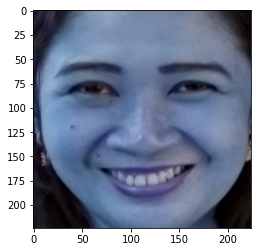

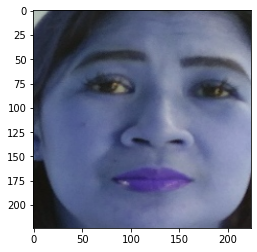

In [18]:
print(labels[show])
plt.imshow((img1.astype(np.uint8)))
plt.show()
plt.imshow((img2.astype(np.uint8)))
plt.show()

In [19]:
import pickle

file1 = open('./labelss','rb')
labels = pickle.load(file1)
file1.close()
#fiel2  = open('')

file2 = open('pairspkl','rb')
pairs = pickle.load(file2)
file2.close()

In [20]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
import datetime
logg = "logs3"
tfcallback = TensorBoard(log_dir=logg)
#ly = EarlyStopping(monitor = 'train_loss',patience = 3) to

2021-10-01 15:46:42.024511: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-01 15:46:42.024555: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-01 15:46:42.025596: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-10-01 15:46:42.047214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2021-10-01 15:46:42.230241: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-01 15:46:42.230457: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [21]:
model.compile(loss="binary_crossentropy", optimizer= Adam(0.001), metrics=["accuracy"])

In [22]:

model.fit([pairs[:, 0], pairs[:, 1]], labels[:],validation_split=0.2,batch_size = 32,
          epochs=80,verbose=2)

2021-10-01 15:46:44.410203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-01 15:46:44.422016: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/80


2021-10-01 15:46:46.029695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-01 15:46:46.747478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-01 15:46:46.787055: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


43/43 - 26s - loss: 1.5897 - accuracy: 0.5000 - val_loss: 0.5738 - val_accuracy: 0.5322
Epoch 2/80
43/43 - 11s - loss: 0.6564 - accuracy: 0.5088 - val_loss: 0.4409 - val_accuracy: 0.6520
Epoch 3/80
43/43 - 11s - loss: 0.5267 - accuracy: 0.5417 - val_loss: 0.3991 - val_accuracy: 0.7807
Epoch 4/80
43/43 - 11s - loss: 0.4700 - accuracy: 0.5857 - val_loss: 0.3739 - val_accuracy: 0.8538
Epoch 5/80
43/43 - 11s - loss: 0.4353 - accuracy: 0.6376 - val_loss: 0.3569 - val_accuracy: 0.9064
Epoch 6/80
43/43 - 11s - loss: 0.4149 - accuracy: 0.6940 - val_loss: 0.3438 - val_accuracy: 0.9211
Epoch 7/80
43/43 - 11s - loss: 0.3958 - accuracy: 0.7357 - val_loss: 0.3362 - val_accuracy: 0.9327
Epoch 8/80
43/43 - 11s - loss: 0.3826 - accuracy: 0.7606 - val_loss: 0.3291 - val_accuracy: 0.9386
Epoch 9/80
43/43 - 11s - loss: 0.3687 - accuracy: 0.8045 - val_loss: 0.3196 - val_accuracy: 0.9591
Epoch 10/80
43/43 - 11s - loss: 0.3556 - accuracy: 0.8302 - val_loss: 0.3145 - val_accuracy: 0.9649
Epoch 11/80
43/43 - 

In [23]:
keyss = model.history.history
nn = len(keyss['loss'])

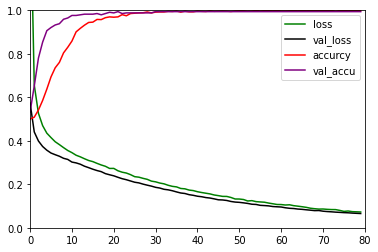

In [24]:

plt.plot(np.arange(nn),keyss['loss'],color='green',label='loss')
plt.legend()
plt.plot(np.arange(nn),keyss['val_loss'],color='black',label = 'val_loss')
plt.legend()
plt.plot(np.arange(nn),keyss['accuracy'],color='red',label = 'accurcy')
plt.legend()
plt.plot(np.arange(nn),keyss['val_accuracy'],color='purple',label = 'val_accu')
plt.legend()
plt.xlim(0,80)
plt.ylim(0,1)
plt.show()



In [25]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
def l2_normalize(xx):
    return xx / np.sqrt(np.sum(np.multiply(xx, xx)))
def findEuclideanDistance(source_representation, test_representation):
    if type(source_representation) == list:
        source_representation = np.array(source_representation)

    if type(test_representation) == list:
        test_representation = np.array(test_representation)

    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

['astari', 'zahid', 'aabid', 'rahee', 'shariq', 'nisar', 'midhat', 'kaiser', 'gowher', 'aafaq', 'aamir', 'loneb', 'arsalan', 'shabir', 'hilal', 'andleeb']


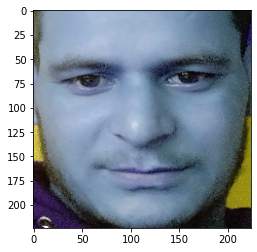

[0.179 0.002 0.159 0.17  0.149 0.146 0.193 0.173 0.15  0.149 0.17  0.176
 0.176 0.173 0.17  0.178]
zahid


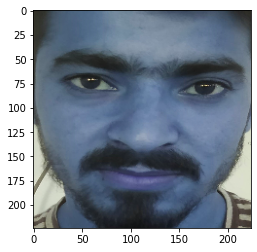

[0.165 0.176 0.11  0.151 0.127 0.086 0.181 0.    0.029 0.114 0.008 0.1
 0.131 0.    0.023 0.171]
kaiser


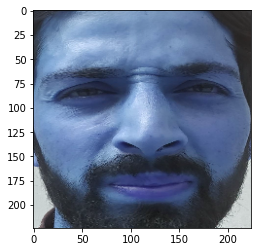

[0.129 0.145 0.099 0.122 0.103 0.067 0.145 0.037 0.014 0.096 0.04  0.076
 0.118 0.037 0.039 0.136]
gowher


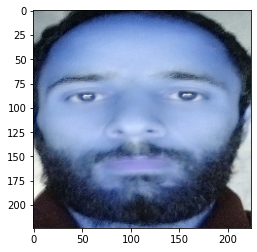

[0.047 0.173 0.041 0.048 0.061 0.078 0.054 0.139 0.115 0.035 0.131 0.052
 0.032 0.139 0.117 0.037]
arsalan


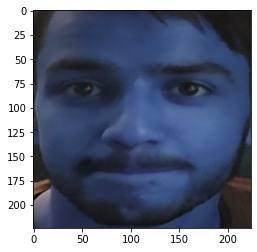

[0.063 0.177 0.054 0.049 0.043 0.077 0.051 0.136 0.111 0.059 0.134 0.063
 0.042 0.136 0.124 0.056]
arsalan


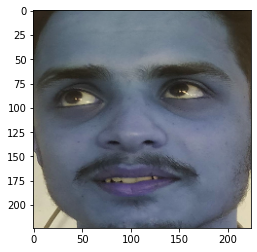

[0.093 0.163 0.074 0.074 0.079 0.062 0.105 0.074 0.06  0.073 0.071 0.057
 0.054 0.073 0.061 0.094]
arsalan


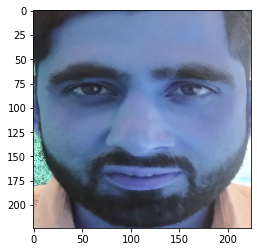

[0.123 0.173 0.089 0.125 0.109 0.074 0.145 0.041 0.043 0.08  0.039 0.078
 0.11  0.041 0.02  0.128]
hilal


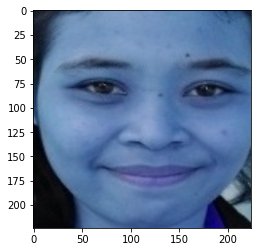

[0.009 0.182 0.071 0.04  0.075 0.088 0.034 0.174 0.138 0.064 0.168 0.079
 0.062 0.173 0.15  0.026]
astari


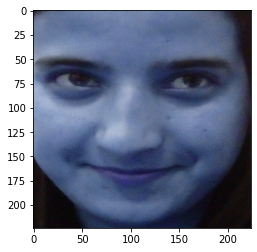

[0.034 0.175 0.066 0.035 0.052 0.084 0.018 0.167 0.13  0.058 0.16  0.065
 0.05  0.166 0.142 0.021]
midhat


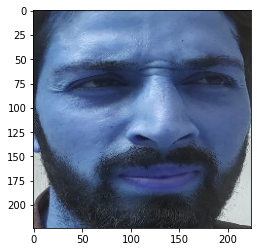

[0.127 0.155 0.098 0.122 0.105 0.066 0.144 0.033 0.012 0.095 0.037 0.07
 0.114 0.032 0.036 0.135]
gowher


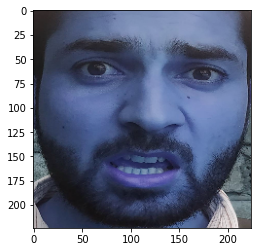

[0.165 0.176 0.11  0.15  0.126 0.085 0.181 0.    0.029 0.113 0.008 0.099
 0.131 0.    0.023 0.17 ]
kaiser


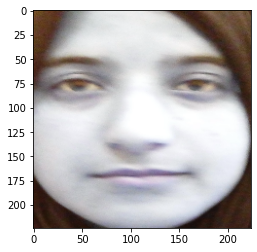

[0.038 0.199 0.075 0.047 0.067 0.105 0.01  0.187 0.152 0.077 0.182 0.082
 0.064 0.187 0.165 0.031]
midhat


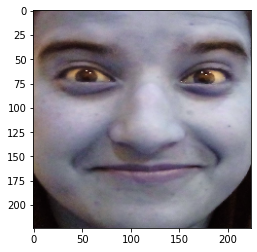

[0.041 0.191 0.068 0.036 0.055 0.094 0.01  0.177 0.143 0.07  0.172 0.075
 0.053 0.177 0.156 0.03 ]
midhat


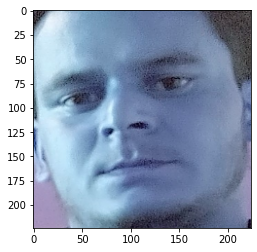

[0.176 0.007 0.158 0.17  0.147 0.145 0.191 0.169 0.145 0.147 0.165 0.174
 0.176 0.168 0.167 0.178]
zahid


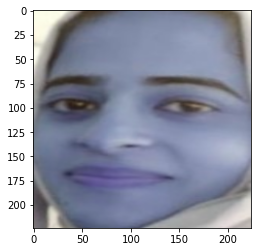

[0.021 0.184 0.076 0.042 0.071 0.095 0.027 0.184 0.147 0.065 0.176 0.077
 0.063 0.183 0.155 0.016]
andleeb


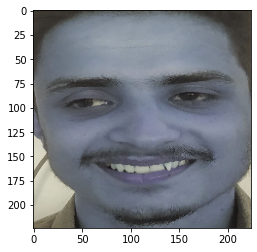

[0.058 0.177 0.068 0.043 0.059 0.063 0.059 0.119 0.098 0.061 0.116 0.052
 0.024 0.119 0.102 0.052]
arsalan


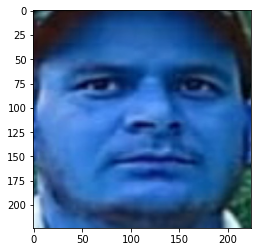

[0.153 0.03  0.133 0.143 0.125 0.12  0.167 0.146 0.121 0.123 0.143 0.147
 0.147 0.146 0.143 0.157]
zahid


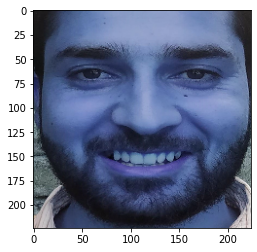

[0.158 0.166 0.107 0.143 0.119 0.081 0.172 0.006 0.027 0.11  0.012 0.097
 0.128 0.006 0.025 0.163]
shabir


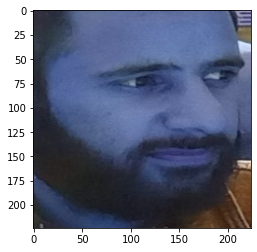

[0.086 0.121 0.047 0.08  0.05  0.066 0.099 0.092 0.07  0.03  0.085 0.064
 0.063 0.091 0.074 0.076]
aafaq


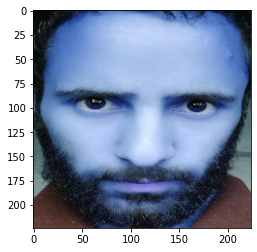

[0.127 0.125 0.088 0.118 0.095 0.074 0.147 0.046 0.043 0.076 0.044 0.086
 0.105 0.046 0.044 0.128]
gowher


In [34]:
from scipy import spatial
datadir = '../input/databaseimg/imagesdb'
classes = [i for i in os.listdir(datadir)]
db = []
for clas in classes:
    path = os.path.join(datadir,clas)
    for img in os.listdir(path):
        img2= cv.imread(os.path.join(path,img))
        img2 = resz3(224,224,img2)
        #newimg=cv.resize(imgarray,(160,160))
        db.append(np.array(img2))
print(classes)
Path = '../input/databasetest/test_images_for_classification'
    
for img in (os.listdir(Path)):
    
    imgarray= cv.imread(os.path.join(Path,img))
    imgsc =  resz3(size,size,imgarray)
    plt.imshow((imgsc.astype(np.uint8)))
    plt.show()
    imgsc = imgsc.reshape(-1,size,size,3,1)
    f1 = extractor.predict(imgsc)
    #f1 = l2_normalize(f1)
    #newimg=cv.resize(imgarray,(160,160))
    dist = []
    for imgref in db:
        
        imgref = resz3(size,size,imgref)
        #plt.imshow((imgref.astype(np.uint8)))
        #plt.show()
        f2 = extractor.predict(imgref.reshape(-1,size,size,3,1))
        dis = spatial.distance.cosine(f1,f2)
        #f2 = l2_normalize(f2)
        #sum_squared = k.sum(k.square(f1 - f2), axis=1)
        #dis = k.sqrt(k.maximum(sum_squared,k.epsilon()))
        
        dist.append(dis)
    print(np.round(dist,3))
    
        
  
    print(classes[np.argmin(dist)])
        
        
        
    

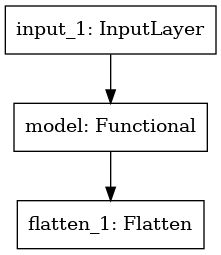

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(extractor,'hii.png') 

<a href="./mod2/variables/variables.data-00000-of-00001"> Download File </a>

In [28]:
extractor.save('./mod2')

2021-10-01 16:01:33.489603: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## 